# Global indicator project - Phoenix, Arizona

## Dwelling density for walkability indicator
(the number of dwelling units standardized by total land area)  
What base land area we should use?



In [2]:
# Libraries used for OSMnx analyses and output
import networkx as nx
import time 
import os
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import geopandas as gpd

from shapely.geometry import shape,Point, LineString, Polygon
import config

ox.config(use_cache=True, log_console=True)
ox.__version__

'0.9'

In [13]:
suffix = config.time
OSM_folder = config.OSM_data_loc
for place in config.places.values():
    place = place

shap_filename = '{studyregion}_shape{suffix}/{studyregion}_shape{suffix}.shp'.format(studyregion = place, suffix = config.time)

### 1. Load county census block group data

In [18]:
blockgroup = gpd.GeoDataFrame.from_file('../data/Maricopa_County/BlockGroup_Data.shp')

In [37]:
blockgroup.head(4)

,TRACTCE10,BLOCKCE,BLOCKID10,HOUSING10,POP10,Sum_Employ,geometry
0,012100,2126,040270121002126,5,15,0.0,"POLYGON ((-113.333767 32.93470400000003, -113...."
1,012100,2122,040270121002122,0,0,0.0,"POLYGON ((-113.333812 33.08803399999996, -113...."
2,012100,2120,040270121002120,7,23,0.0,"POLYGON ((-113.333801 33.07349199999997, -113...."
3,012100,2119,040270121002119,0,0,0.0,"POLYGON ((-113.333797 33.05896800000004, -113...."


### 2. Load city boundary shapfile (OSM)

In [14]:
Phx_studyregion = gpd.GeoDataFrame.from_file(OSM_folder + '/' + shap_filename)

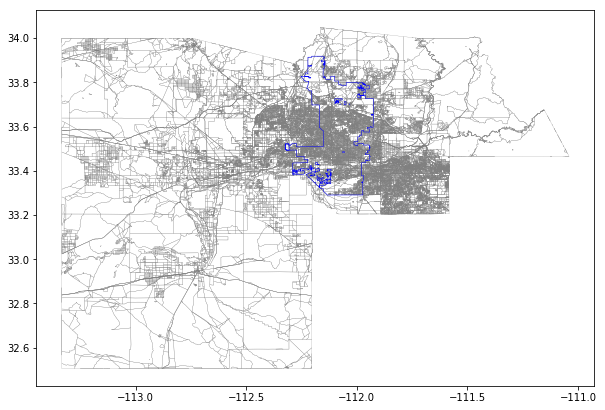

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = blockgroup.plot(ax=ax, facecolor="none", edgecolor='grey', linewidth=0.2)
ax = Phx_studyregion.plot(ax=ax, facecolor="none", edgecolor='blue', linewidth=0.5)
plt.show()

### 4. plot dwellings by census block group within the county

In [23]:
def map_variable(df, df1, col):
    values = df.dropna(subset=[col])
    ax = values.plot(column=col, scheme='quantiles', k=6, cmap='YlOrBr', figsize=(10,10))
    ax = df1.plot(ax=ax, facecolor="none", edgecolor='blue', linewidth=1)
    plt.show()

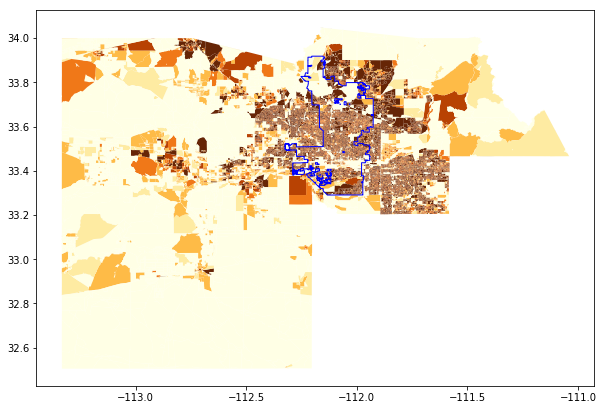

In [28]:
map_variable(blockgroup, Phx_studyregion, 'HOUSING10')

### 5. select census block group within city boundaries

In [20]:
# find all the block group within Phx
Phx_studyregion_polygon = Phx_studyregion['geometry'].iloc[0]

Phx_blockgroup = blockgroup[blockgroup.within(Phx_studyregion_polygon)]
len(Phx_blockgroup)

20107

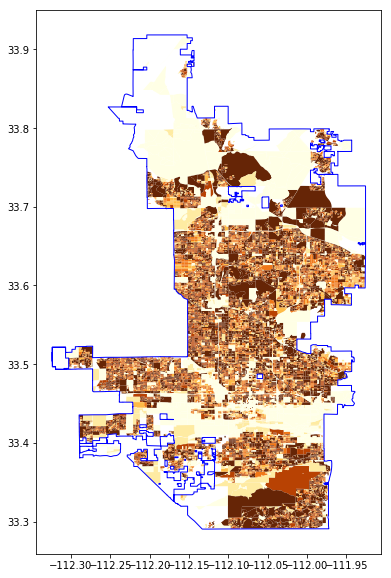

In [24]:
map_variable(Phx_blockgroup, Phx_studyregion, 'HOUSING10')

### 6. calculate city land area (projected)

In [30]:
# specify the width and height of the map extent/domain in projection coordinate units (meters) - approx USA dimensions
map_width_m = 5000 * 1000 #5000 km
map_height_m = 3500 * 1000 #3500 km

# Albers Conical Equal Area projection for USA
albers_usa = {'datum':'NAD83',
              'ellps':'GRS80',
              'proj':'aea', 
              'lat_1':33, 
              'lat_2':45, 
              'lon_0':-97, 
              'lat_0':39, 
              'x_0':map_width_m/2, 
              'y_0':map_height_m/2,
              'units':'m'}

In [31]:
Phx_studyregion_proj = Phx_studyregion.to_crs(albers_usa)
Phx_blockgroup_proj = Phx_blockgroup.to_crs(albers_usa)

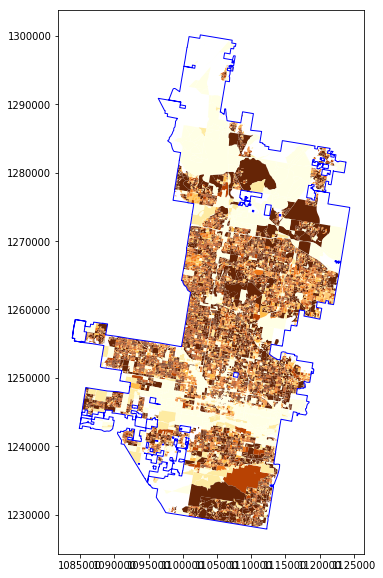

In [32]:
map_variable(Phx_blockgroup_proj, Phx_studyregion_proj, 'HOUSING10')

In [49]:
#calculate land area in sq km
Phx_studyregion_proj['area'] = Phx_studyregion_proj.area / 1e6 # sq meters -> sq km
Phx_studyregion_proj['area'][0]

1347.8011902710205

### 7. calculate total number of dwellings within the city

In [50]:
num_dwelling = Phx_blockgroup_proj['HOUSING10'].sum()
print (num_dwelling)

574294


### 8. calculate the dwelling density

In [51]:
density_dwelling = num_dwelling / Phx_studyregion_proj['area'][0] #number of dwelling units per sq km of city land area
print (density_dwelling)

426.0969675242081